**Why we used the mediapipe Holistic Model?**

Many people used the pre-trained MobileNet Model followed by a bunch of LSTM layers.But, we are Not getting the state of art results.

We used the Mediapipe Holistic Model followed by LSTM Layers:

1. We need less data to produce a hyper acurate Model

2. It was much denser network. So, rather than having around 30-40 million parameters in our Neural Network; so by using mediapipe holistic model we have around half a million parameters. This made our model way faster and train that particular model.

3. Because the Neural Network was a lot simpler and meant it was going to be a whole heap faster when it comes to detecting in real time.

**Goal:**

Real time sign language detection using sequences

i. Extract holistic keypoints

ii. Train an LSTM DL Model

iii. Make real time predictions using sequences

How it works:

i.Collect keypoints from mediapipe holistic and will store that keypoints as a numpy array

ii.Train a deep Neural Network with LSTM layers for sequences

iii.Perform real time sign language detection using OpenCV

# 1. Import and Install Dependencies

In [1]:
!pip install opencv-python mediapipe sklearn matplotlib

In [2]:
import cv2      #importing OpenCV
import numpy as np      #help us working with Array
import os     #help us work with the file paths
import matplotlib.pyplot as plt   #for Visualisation purpose
import time       #we will be using time to take a sleep between each frame that we collect
import mediapipe as mp

In [3]:
import tensorflow as tf

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Keypoints using MP Holistic

First, we will be making sure that we can access our webacams using OpenCV and then we will be applying a secondary layer where we will be actually going to make detections using Mediapipe.

Basically, we are setting up a video capture then we are going to loop through every single frame and actually render that to the screen, so even though we are looping through frame it is going to look like a video since a video is multiple frames stack together.

Now, we will creating two variables one for creating one for mediapipe holistics and another one for mediapipe drawing utilities.

Holistics will be downloading the model and leveraging that model. Whereas the drawing utilities is just going to make it easier to actually draw the keypoints on our face.

NOTE: We will using them as functions eventually because we are going to use them so often.

In [6]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

We will be creating a function where we will pass two variables image and Mediapipe Holistic model.

So, we need to perform a bunch of steps inorder to make a detection with Mediapipe.

First, we need to grab the image that we converted from bgr to rgb since OpenCV uses BGR image format.BUt, when we actually need ti make a detection using mediapipe we need it to be in the format of rgb.
[link text](https://www.geeksforgeeks.org/convert-bgr-and-rgb-with-python-opencv/)

We then set it to unwritable since it saves some memory and then we make our detections and convert it or set it back to writable and then convert it from rgb to bgr.

Important link: [link text](https://https://www.geeksforgeeks.org/python-facial-and-hand-recognition-using-mediapipe-holistic/)

In [7]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction;NOTE: image is going to be our frame from OpenCV
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results                           # we will be returning this two values back to our loop

cv2.cvrColor() is a function that allows us to change or recolor our images ie., it converts an input image from one color space to another.And, Note that the order of the channels should be specified explicitly(RGB or BGR).

In [ ]:
cv2.cvtColor??    #Docstring

Function to draw landmarks on our frame; this is the default function in whichw e havent done the formatting ; the draw_styled_landmarks function we defined is with the formatting which is written below.

In [8]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections maps
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [ ]:
mp_drawing.draw_landmarks??   #gives brief summary of the inbuilt function; this is just a helper function that comes with the Mediapipe that makes it easier to draw landmarks onto an image 

In [ ]:
mp.holistic.POSE_CONNECTIONS      #this shows what one landmark conncects to other landmarks

The below block is just for Formatting.

Here we are specifying the optional arguments for mp_drawing_drawa_landmarks().

mp_drawing.draw_landmarks takes argument as image, landmark_list , connections (what type of connection you want) , and the optional args are :landmark_drawing_spec,connection_drawing_spec , this both are used for formatting purpose.

landmark_drawing_spec is saying what formatting do you want to apply to the dots, so effectively the joints  

connection_drawing_spec is what format you want to apply to the connections 


In [9]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [17]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [12]:
results   # to get the solution output ; this is also to check whether the Mediapipe is taking into account the coordinates

mediapipe.python.solution_base.SolutionOutputs

In [13]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

We can have different modules with results. This are count, face_landmarks, index, left_hand_landmarks, mro , pose_landmarks, right_hand_landmarks

In [18]:
results.face_landmarks  #this will give us the x,y and z coordinates, where z is the relative distance from the camera

landmark {
  x: 0.49907264
  y: 0.6405967
  z: -0.022497049
}
landmark {
  x: 0.49857396
  y: 0.6105759
  z: -0.036668956
}
landmark {
  x: 0.49860287
  y: 0.6214434
  z: -0.02092753
}
landmark {
  x: 0.4924497
  y: 0.5826961
  z: -0.025615346
}
landmark {
  x: 0.49851027
  y: 0.6011137
  z: -0.038318135
}
landmark {
  x: 0.4983265
  y: 0.58977497
  z: -0.034821507
}
landmark {
  x: 0.49796632
  y: 0.5640656
  z: -0.014205874
}
landmark {
  x: 0.4501129
  y: 0.5684134
  z: 0.010990566
}
landmark {
  x: 0.49777627
  y: 0.5428938
  z: -0.007973055
}
landmark {
  x: 0.49773118
  y: 0.5308055
  z: -0.008184711
}
landmark {
  x: 0.4972352
  y: 0.4930138
  z: 0.002475903
}
landmark {
  x: 0.4991567
  y: 0.64504933
  z: -0.021984221
}
landmark {
  x: 0.4991811
  y: 0.64872515
  z: -0.020050438
}
landmark {
  x: 0.4991357
  y: 0.6504457
  z: -0.017340796
}
landmark {
  x: 0.49930295
  y: 0.6630042
  z: -0.015252616
}
landmark {
  x: 0.4993696
  y: 0.6671487
  z: -0.01659666
}
landmark {
  x: 0

In [19]:
results.face_landmarks.landmark   #this will convert it to a list

[x: 0.49907264
y: 0.6405967
z: -0.022497049
, x: 0.49857396
y: 0.6105759
z: -0.036668956
, x: 0.49860287
y: 0.6214434
z: -0.02092753
, x: 0.4924497
y: 0.5826961
z: -0.025615346
, x: 0.49851027
y: 0.6011137
z: -0.038318135
, x: 0.4983265
y: 0.58977497
z: -0.034821507
, x: 0.49796632
y: 0.5640656
z: -0.014205874
, x: 0.4501129
y: 0.5684134
z: 0.010990566
, x: 0.49777627
y: 0.5428938
z: -0.007973055
, x: 0.49773118
y: 0.5308055
z: -0.008184711
, x: 0.4972352
y: 0.4930138
z: 0.002475903
, x: 0.4991567
y: 0.64504933
z: -0.021984221
, x: 0.4991811
y: 0.64872515
z: -0.020050438
, x: 0.4991357
y: 0.6504457
z: -0.017340796
, x: 0.49930295
y: 0.6630042
z: -0.015252616
, x: 0.4993696
y: 0.6671487
z: -0.01659666
, x: 0.499423
y: 0.67240554
z: -0.01807638
, x: 0.49943137
y: 0.67819357
z: -0.016899856
, x: 0.49932837
y: 0.6876708
z: -0.0107682375
, x: 0.49853715
y: 0.6158967
z: -0.033618994
, x: 0.49225298
y: 0.61616236
z: -0.024853058
, x: 0.42678857
y: 0.54119647
z: 0.04532941
, x: 0.4691943
y: 0.

**Note: Landmark Values:**

**The face and hand landmark models will return no values if nothing is detected.**

**The Pose_model will return landmarks but the visibility value inside of each landmark will be low.**

In [20]:
len(results.face_landmarks.landmark )   #to find how many landmarks our face got and make sure the landmarks which we want that body part should be present in the frame

468

In [21]:
frame     #this is the last frame that we have extracted from our webcam before pressing the key 'q' from keyboard

array([[[155, 183, 192],
        [156, 183, 192],
        [157, 183, 192],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[157, 185, 199],
        [158, 186, 198],
        [156, 183, 195],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[157, 186, 192],
        [159, 185, 193],
        [158, 184, 193],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 57,  83, 101],
        [ 51,  80, 101],
        [ 48,  82, 104],
        ...,
        [138, 167, 203],
        [144, 172, 210],
        [151, 179, 217]],

       [[ 66,  94, 110],
        [ 61,  89, 107],
        [ 63,  91, 111],
        ...,
        [149, 173, 204],
        [169, 195, 224],
        [165, 190, 219]],

       [[ 51,  73,  89],
        [ 48,  71,  90],
        [ 42,  67,  90],
        ...,
        [151, 174, 206],
        [155, 180, 212],
        [167, 192, 224]]

In [22]:
results    #this is the last result of the last frame 

mediapipe.python.solution_base.SolutionOutputs

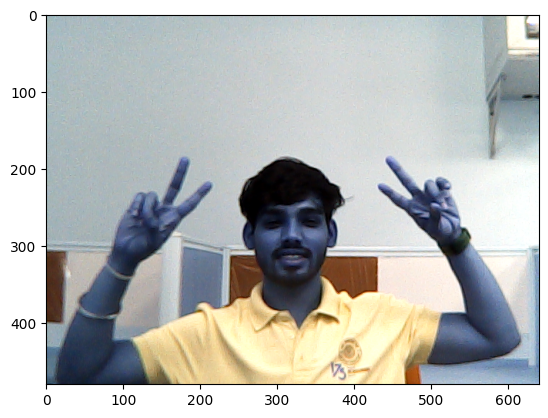

In [23]:
plt.imshow(frame)   #this is the last frame; and the colors are little bit off since we havent done color conversion till now

In [24]:
draw_landmarks(frame, results)    #apply results on our frame

**draw_landmarks:**

The draw_landmarks function does not return the image but rather applies the landmark visualisations to the current image in place.

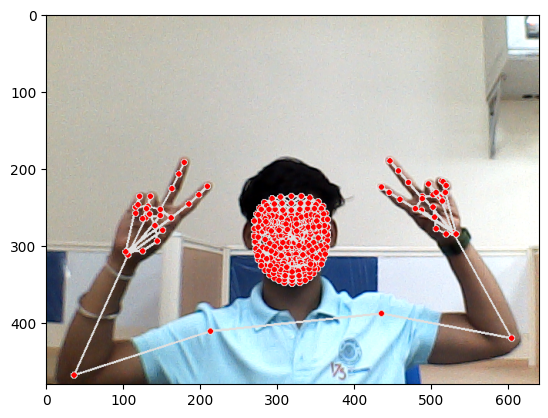

In [25]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))    #here we are doing the color conversions and drawing landmark functions specifically these mp_drawing.draw_landmark() methods are going to apply to the frame inplace so itsnot going to return a variable, it's going to apply to that current frame

# 3. Extract Keypoint Values

In [26]:
results   #we can access our last result through the results variable ; and to access different components we can type dot(.) and we can access different landmarks

mediapipe.python.solution_base.SolutionOutputs

In [27]:
len(results.left_hand_landmarks.landmark)   #gives the length of left hand landmarks

21

In [28]:
len(results.pose_landmarks.landmark)    #multiply with 4 and pass that much number of zeroes

33

In [29]:
len(results.right_hand_landmarks.landmark)

21

The below four lines extract this one set landmarks for one of our keypoints which have displayed above using results.

In [30]:
results.pose_landmarks.landmark[0].x

0.5139204859733582

In [31]:
results.pose_landmarks.landmark[0].y

0.626723051071167

In [32]:
results.pose_landmarks.landmark[0].z

-0.7023784518241882

In [33]:
results.pose_landmarks.landmark[0].visibility

0.9999287724494934

**Input Data:**

The input data used for this action detection model is a series of 30 arrays each of which contains 1662 values(30,1662).

Each of the 30 arrays represents the landmark values (1662 values) from a single frame.

The below code:
We need to extract these in a way that we are going to concatenate this in a numpy array and if we dont have values at a point in time we are just going to create a numpy 0's array, so that an array with the same shape with 0's and we are going to sub that in .

Now, we need to get this landmarks for all the keypoints in one flattened array.

In [34]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [35]:
len(pose)   #NOTE: The length of results.pose_landmarks.landmark and the length of pose is same

33

we have stored this one flattened array since it gives us the ability to work with each one of these landmarks.

The below line is just the reformatting,and does the same work as the above line. Rather than doing this in a loop as we did in above code, we can do this as a list comprehension as we did in the below code.

Note: With flattened, we are reshaping and  we will get all our landmarks in just one big array, and without flattened, we are just getting multiple sets of landmarks. 

We did flattening since we want it in this format to pass it to our LSTM model.

NOTE:

We also need to the reformatting in list comprehension for Pose_landmarks, face_landmarks, left_hand_landmarks, right_hand_landmarks.

**Note: Our Face, left_hand and right_hand landmarks doesn't have the visibility so we will ignore that parameter.**

In [36]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)  #33*4
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)     #468*3
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

**Note: If our right hand or left hand or face isn't visible in the frame, the np.array function for right hand or left hand will through an error and so we need to do some Error handling, incase if they are not visible we will return an array full of 0's ie., blank error**

In [41]:
len(results.face_landmarks.landmark)   #o/p:468; this code will return the length; then multiply this value with 3; and return this no. of zeroes when we dont have face captured in our frame

468

res.x , res.y , res.z this are the each of the individual values for one landmarks. And we are effectively putting under one array.

In [ ]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
    if results.face_landmarks 
    else np.zeros(1404)   #no. of zeroes we need to return if we didnt have face in the frame captured; this is for error handling
                          #we need to modify this value for different frames captured
                          #the np. of zeroes here we got is 468*3

The below function is extracting the keypoints and converting them into a numpy array. And, then we are concatenating all of these(pose,face, left_hand, right_hand) together. And, we will be using all of those keypoints to do our sign language action detection.

In [44]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [45]:
extract_keypoints(results)[:10]   #this will give me first 10 values

array([ 0.51392049,  0.62672305, -0.70237845,  0.99992877,  0.53174675,
        0.57689917, -0.635414  ,  0.99991018,  0.54329365,  0.57549465])

we are getting all of our keypoints inside a flat array in result_test.

In [46]:
result_test = extract_keypoints(results)

In [47]:
result_test.shape   #this will output all the keypoints 1662=468*3+33*4+21*3+21*3

(1662,)

In [48]:
result_test

array([ 0.51392049,  0.62672305, -0.70237845, ...,  0.18182305,
        0.53848237, -0.02728868])

In [49]:
np.save('0', result_test)   #this will saving our numpy array which is stored in result_test in the file 0 in the folder directory we created.

In [50]:
np.load('0.npy')    #we can load the backup

array([ 0.51392049,  0.62672305, -0.70237845, ...,  0.18182305,
        0.53848237, -0.02728868])

# 4. Setup Folders for Collection

**Action Detection:**

A key difference between action detection and other computer vision task is that a sequence of data rather than a single frame is used for detection.

Here, we are going to use 30 different frames of data so 30*1662 keypoints to be able to detect that particular action; and we are specifically going to do for each of these actions. So, effectively we are going to be collecting data for three different actions multiplied by 30 frames multiplied by the number of  sequences that we want to collect. So, we will be working with 3 actions * 30 videos * 30 frames(ie., each video is 30 frame) * 1662 keypoints of data.

In [59]:
#step5: Then perform this cell
import os

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')
#DATA_PATH = os.path.join('/Users/imava/Documents/PROJECTS/MP_Data')
#DATA_PATH = os.makedirs("/Users/imava/Documents/MP_Data")

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [58]:
#step 0 and 4th: Print the current directory
import os

cwd = os.getcwd()
print(cwd)



C:\Users\imava\Documents\PROJECTS\MP_Data


In [57]:
#step2: to join the folders
os.chdir(os.path.join("Users","imava","Documents","PROJECTS","MP_Data"))


In [56]:
#step1; to get to the root folder
import os

# Navigate to the root directory
os.chdir('/')

# Check the current working directory to make sure you have navigated to the root directory
print(os.getcwd())


C:\


we will be creating some folders , each folder for each action(hello, thanks, iloveyou).

Within each one of these subfolder we are going to have a folder for each sequence of action, so we are going to have 0,1,..,29.(30 videos)

So, we are effectively going to be storing each one of our 30 frames inside each of these folders. So for sequence 0, we are going to have 30 different frames worth of data ie., 30 different keypoints worth of data from abstract keypoints values



In [62]:
for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass

In [61]:
#if the above cell dont run properly then only perform the below cell; the above cell is important
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

NOTE: If the folder exists then it will through an error.

**Data:**

Just to recap, we are going to collect 30 videos per action ie., hello, thanks, ily.

Then each one of those videos are sequences are going to contain 30 frames of data. Each frame will contain 1662 landmark values ie, 3*30 sequences, 30 frames, 1662 landmarks


# 5. Collect Keypoint Values for Training and Testing

Now, since we have created the folders and Now let's start collecting the data.
Inorder to start out this we are copying the above Mediapipe loop code block and will modify it.

Now, rather than looping through our webcam, we are going to loop through and specifically take a snapshot at each point in time. So, we are going to loop through each one of our actions ie., collect our actions and then we are going to loop through and collect a set of frames per video.

30 frames of keypoints per video for each action.



If we run the code, it will be start collecting the frames so quickly that we would barely have time to actually go and collect all those different frames. So, we will be adding some break between each one of the frames that are being collected.

**Collection Breaks:**

Having breaks between each sequence collection allows you to reset and reposition yourself to collect action from start to finish.

The arguments for starting for cv2.putText is the image, followed by the text you want to print on the middle(120,120) of the screen, then we will specify the coordinates x and y ie., here 120 pixels by 120 pixels. Then we will specify the font we will be using ,here HERSHEY_SIMPLEX, followed by font size ie., 1 here; followed by font color (0,255,0) ie., green ; followed by the line width ie., 4 here; followed by the line type which is cv2.LINE_AA.

The next block for cv2.putText block has arguments image; followed by the text that we are collecting and printing "Collecting frames for particular action" on the top(15,12) of the screen and we are using some string formatting to pass through that action and we will also specify the video number. The following arguments are same as done for starting frame.


NOTE: And when we are not at the frame -0 ie., starting frame we will be executing the else block.

In [63]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0:          #if we are at frame 0 then we are going to take a break
                    #the below 2 lines of code of cv2.putText is optional and it is for outputting text to our screen. We can skip these but it will be hard to know when frames are starting and when NOT.
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)   
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)                #0.5 second break
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))   #this is where we are actually going to save our frame and its specifically the frame name
                np.save(npy_path, keypoints)

                # Break gracefully                              #we need this to inline with our loop so we should get a graceful break between each one of those collection runs that we actually get
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [64]:
cap.release()         #this code block is to release the webcam and we have to execute this cell before again trying to access the webcam
cv2.destroyAllWindows()

**Shorten Breaks:**

Inorder to shorten the breaks between sequences collected change the value in cv2.waitTime() to a lower value. To increase the time increase the value.

# 6. Preprocess Data and Create Labels and Features

In [66]:
pip install -U scikit-learn

     ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.4 MB 217.9 kB/s eta 0:00:39
     ---------------------------------------- 0.0/8.4 MB 217.9 kB/s eta 0:00:39
     ---------------------------------------- 0.1/8.4 MB 273.8 kB/s eta 0:00:31
     ---------------------------------------- 0.1/8.4 MB 327.7 kB/s eta 0:00:26
      --------------------------------------- 0.1/8.4 MB 379.3 kB/s eta 0:00:22
      --------------------------------------- 0.2/8.4 MB 437.1 kB/s eta 0:00:19
     - -------------------------------------- 0.2/8.4 MB 550.0 kB/s eta 0:00:15
     - -------------------------------------- 0.3/8.4 MB 679.5 kB/s eta 0:00:12
     - -------------------------------------- 0.4/8.4 MB 782.8 kB/s eta 0:00:11
     -- ------------------------------------- 0.5/8.4 MB 1.0 MB/s e

In [67]:
from sklearn.model_selection import train_test_split  #for spliting the data into training and testing set
from tensorflow.keras.utils import to_categorical   #this will help us with the labels when we are doing OneHotEncoding

In [68]:
label_map = {label:num for num, label in enumerate(actions)}    #we will be creating a label map to represent each one of our different actions

In [69]:
label_map   #this is stored as in the form of dictionary

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

The below code is for bringing all of our data together and structuring it.

Remember as we had 1662 values (468*3+33*4+21*3+21*3) per sequence ;  now we want to create a big array which contains all of our data. So, we will end up with 90 arrays with 30 frames in each one of those arrays with 1662 values which represents our keypoints in each. 

Sequence is going to effectively represent our feature data or X data. And, our labels data is effectively going to represent our labels or Y data.

So, we are going to use our features to train our model to represent the relationship between our labels.

In [ ]:
#commented
sequences, labels = [], []    #creating two blank arrays as sequences and labels
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []       #we are creating a blank array called window ; and this is going to represent all of the different frames that we have got for that particular sequence
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
#commented
sequences, labels = [], []    #creating two blank arrays as sequences and labels
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []       #we are creating a blank array called window ; and this is going to represent all of the different frames that we have got for that particular sequence
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [78]:
sequences, labels = [], []    #creating two blank arrays as sequences and labels
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(abs_path, action))).astype(int):
        window = []       #we are creating a blank array called window ; and this is going to represent all of the different frames that we have got for that particular sequence
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(abs_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [76]:
import os

# Replace the file path with your own file path
file_path = 'C:/Users/imava/Documents/PROJECTS/MP_Data/MP_Data'

# Get the absolute path of the file
abs_path = os.path.abspath(file_path)

# Print the absolute path
print(abs_path)

# Store the absolute path in a variable
file_abs_path = abs_path

# Print the variable
print(file_abs_path)


C:\Users\imava\Documents\PROJECTS\MP_Data\MP_Data
C:\Users\imava\Documents\PROJECTS\MP_Data\MP_Data


In [ ]:
#os.chdir(os.path.join("Users","imava","Documents","PROJECTS","MP_Data"))

In [79]:
np.array(sequences).shape

(90, 30, 1662)

In [80]:
np.array(labels).shape

(90,)

In [81]:
X = np.array(sequences)

In [82]:
X.shape

(90, 30, 1662)

In [83]:
y = to_categorical(labels).astype(int)      #we are doing OneHotEncoding on labels that are hello, thankyou, ily

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)     #training 95% and testing 5%

In [85]:
y_test.shape

(5, 3)

# 7. Build and Train LSTM Neural Network

In [101]:
from tensorflow.keras.models import Sequential   #sequential will allow us to build a sequential neural network
from tensorflow.keras.layers import LSTM, Dense   #this gives us the temporal layers to build us our neural network and allow us to perform our action detection and then pass through the dense layer which is a normally fully connected layer
from tensorflow.keras.callbacks import TensorBoard    #this will allow us to perform some logging inside of tensorboard; if we wanted to go and trace and monitor our model as our model is training

Now, we need to just create a log directory and set up our tensorboard callbacks

**Tensorboard is basically a web App that's offered as a part of the tensorflow package that allow us to monitor our neural network training.**

So, if we want to monitor your training and your accuracy as it's being trained ; then we should use the Tensorboard.

In [104]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

NOTE: The best thing about sequential API is that it makes it easy to build up your model, you can just add in a bunch of layers pretty straightforward.

**Note: When you are using Tensorflow with LSTM layer, if we are going to stack them together we need to return the sequences because the next layer is going to need them. So, by specifying the return_sequences = True, we will be able to do that.**

In [105]:
model = Sequential()    #instantiating the model specially the sequential API
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))    #input shape is going to be 30 frames per predictions multiplied by 1662 keypoint values
model.add(LSTM(128, return_sequences=True, activation='relu'))    #128 LSTM Units
model.add(LSTM(64, return_sequences=False, activation='relu'))    #NOTE: here the return_sequences is set to False since the next layer is the dense layer 
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))    #this is the action layer; this is effectively extracting the actions 

**Softmax activation function returns the values that are within a probability of 0 to 1 with the sum of all the values returned adding up to 1**

The highest or maximum probability within that array represent the action that's been detected

In [106]:
actions.shape[0]      #extracting the actions of shape 0 which is effectively three neural network units

3

The below code compiles our model.

We have used the Adam Optimiser.

The metrics argument is optional and it is used to track our accuracy as we train our model.

**NOTE:**

**We must use the LOSS function as 'Categorical_CrossEntropy' since when we are having multi-class classification.
Whereas, when we have a Binary Classification Model, we use 'Binary Cross Entropy'; And if we are using Regression with Neural Network we will be probably using 'Mean Squared Error'.**

In [107]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

This below code trains our model.

**The cool thing about using the Mediapipe Holistic Model in this case is that more often that not the data is going to be able to fit into memory, so we don't need to build a data generator inorder to be able to build up a pipeline of data fits in more often that not its all going to fit into the memory and we will be able to train.**

Note:

NUMBER OF EPOCHS:

-> 2000 epochs may be a bit higher for training with such a low amount of data.

-> Feel free to 'stop training early' if accuracy is acceptable and loss has stopped consistently decreasing.




In [108]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 8s 2s/step - loss: 7.0605 - categorical_accuracy: 0.3882
Epoch 2/2000
3/3 [==============================] - 1s 234ms/step - loss: 1.9630 - categorical_accuracy: 0.3412
Epoch 3/2000
3/3 [==============================] - 1s 167ms/step - loss: 2.5415 - categorical_accuracy: 0.3294
Epoch 4/2000
3/3 [==============================] - 1s 182ms/step - loss: 1.1218 - categorical_accuracy: 0.4118
Epoch 5/2000
3/3 [==============================] - 1s 176ms/step - loss: 3.5274 - categorical_accuracy: 0.2706
Epoch 6/2000
3/3 [==============================] - 1s 177ms/step - loss: 1.0574 - categorical_accuracy: 0.3412
Epoch 7/2000
3/3 [==============================] - 1s 189ms/step - loss: 0.9460 - categorical_accuracy: 0.5529
Epoch 8/2000
3/3 [==============================] - 1s 177ms/step - loss: 0.8507 - categorical_accuracy: 0.6353
Epoch 9/2000
3/3 [==============================] - 1s 179ms/step - loss: 0.8638 - categorical_accuracy: 0.

KeyboardInterrupt: 

While the above code runs, we can track the accuracy of our model in real time using Tensorboard.

To open the TensorBoard open the cmd prompt, then navigate to the folders using cd command, continue navigating until you open the 'log' folder , and then to 'train' folder inside the log folder where you can see the log files.

Then we reach the train folder then to open the tensorboard simply type **tensorboard --logdir=.** , this will open the tensorboard from within the current folders so if we run this command, it will give us the link( eg. https://localhost:6006/ ) to go and access tensorboard; then copy that link and paste in the browser and this will open the tensorboard where we can see the accuracy and loss graph; we can also see our Model architecture; we can also see the Time Series data to check our training accuracy and epoch loss.

In [109]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 128)           98816     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
________________________________________________

# 8. Make Predictions

In [110]:
res = model.predict(X_test)

NOTE: 

eg. if our result returns ie., res = [0.7, 0.2, 0.1] ; this gives three values here this is a multiclass classification.

that means the action corresponding to action 0 ie., hello is having probability of 0.7; action 1 ie., thank you having prob of 0.2 and ily with prob 0.1

when we use np.argmax(res) this will return 0 ie., 0th action since it is having maximum probability

And when we do  actions[np.argmax(res)] it will return that action ie, here 'hello' which is corresponding to 0th action.

In [ ]:
#commented block

model.predict(X_test)     #this will give us the all the predictions in form of probabilities of labels in an array; so we need to unpack them so we will be storing them in a variable


In [ ]:
#commented block

res = model.predict(X_test)
res[0]    #this will gives us the 1st sequence result which is in form of probabilities

In [ ]:
#Commented block
#to know what res[0] actually means we can use the argmax function
np.argmax(res[0])   #this will output 0 or 1 or 2 corresponding to differnt actions

#we also know that since they are probabilties they will sum upto 1
np.sum(res[0])    #output 1

In [111]:
actions[np.argmax(res[4])]      #Actual action

'hello'

In [112]:
actions[np.argmax(y_test[4])]     #prediction result,NOTE: both the actions are same, this means our prediction is correct

'hello'

# 9. Save Weights

It is always better to go and save our values for the model when we have trained a neural network inorder to leverage it later on.

In [113]:
model.save('action.h5')   #we can now go and see that the action.h5 file is now created which saves our weights for the model

NOTE: 

Let's say we deleted our model, then we need to go (in the Section 7. Build and Train LSTM Neural Network) and run the model rebuild(model = sequential ) block, and then compile the model ( model.compile() block ) and then run the below code to load the model ( model.load_weights('name of our weights ) block.

In [ ]:
del model     #DON'T RUN THIS CELL UNTIL YOU WANT TO DELETE THIS MODEL

In [ ]:
model.load_weights('action.h5')   #FOR RE-LOADING OUR MODEL AGAIN

# 10. Evaluation using Confusion Matrix and Accuracy

The multilabel_confusion_matrix will give us the confusion matrix for each one of our labels and this allows us to evaluate what's being detected as true postive and true negative; and what's being detected as false positive and false Negative.

In [114]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [115]:
yhat = model.predict(X_test)

**Conversions**

Running these below cells converts the predictions from their one-hot encoded representation to categorical labels,

eg. 0,1 or 2 as opposed to [1,0,0] , [0,1,0] ,or [0,0,1].

In [116]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [117]:
multilabel_confusion_matrix??     

SyntaxError: invalid syntax (2590813483.py, line 1)

multilabel_confusion_matrix returns a confusion matrix of shape 2,2. 

**Confusion Matrix:**

The mcm function returns a confusion matrix sorted by the label orders, in this case 0,1,2 aka hello, thankyou, ily.

The matrix is organised as follows:

[[ TN  FP],

  [FN  TP]]

In [118]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[2, 0],
        [0, 3]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [119]:
accuracy_score(ytrue, yhat)     #accuracy on our test set; we got 100% accuracy since our data was small

1.0

We can also run the above Evaluation on train set(NOT ADVISABLE); just we need to change test to train wherever it is written in the above 10 th section.

# 11. Test in Real Time

In [120]:
from scipy import stats

The below block is for probability visualisation.

In [121]:
colors = [(245,117,16), (117,245,16), (16,117,245)]     #for coloring differnt array ie. for hello, thanks, ily ; different color for each action
#The results we get from our predicted model is our actions,input_frame which is our image and then the colors that we assigned for different actions
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)     #we are drawing a dynamic rectangle and putting that on our output frame then we are dynamically positioning it based on the position or the action we are currently working through (0,60+num*40) where num is number of the action(0th action ,1st or 2nd, 40 is multiplied since it moves up and down dynamically
                #(int(prob*100) this will going to change the length of our bar depending upon high our probaility is; (90+num*40) is the end point of our frame; then followed by the color we want to put; so here the 1st color is hello; second is going to be thanks; 3rd ily; and -1 represents that fill the rectangle with color
        
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

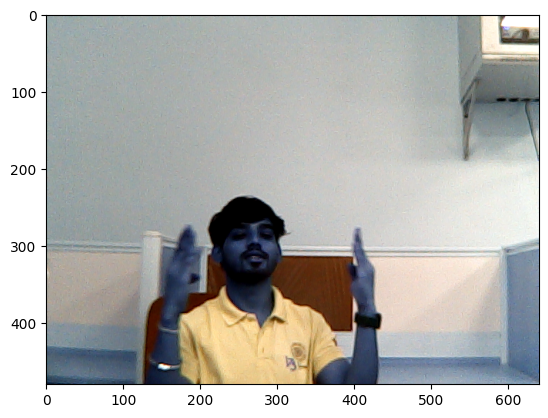

In [122]:
plt.imshow(frame)     #this is our last frame, in this there is no detection and also no keypoints drawn on it

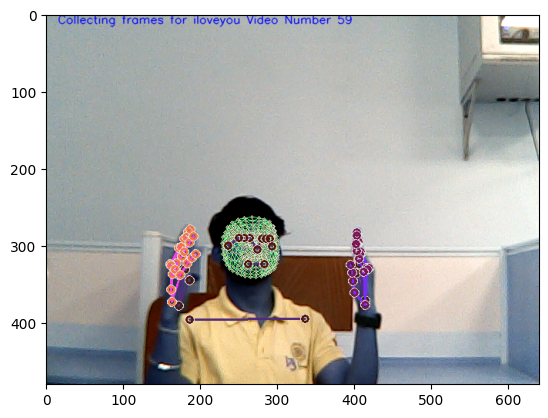

In [123]:
plt.imshow(image)   #keypoints drawn on it

In [ ]:
plt.figure(figsize=(18,18))     #for making the picture bigger
plt.imshow(prob_viz(res, actions, image, colors))   #probability visualisation on our last frame

To implement the prediction logic or generating prediction we need 30 frames of data so we will concatenating our data into sequence then once we have got 30 frames of data then we will be going to make a prediction.

We are using np.expand_dims(sequence,axis))[0] because:

when we run:

model.predict(X_test)   #returns an array of prediction and when we try to grab one frame, it will through an error

model.predict(X_test[0])  #error since the shape is incorrect

X_test[0].shape   #output: (30,1662)

But our model us expecting the shape in form of (number_of_sequences, 30, 1662) ie. (1,30,1662) , so we need to encapsulate this number_of_sequences inside another array, so this can be done by np.expand_dims(number_of_sequence, axis=0)

NOTE: 

when we run np.expand_dims(X_test[0],axis=0).shape

-> if axis=0, then output will be (1,30,1662)

-> if axis=1, then output will be (30,1,1662)


And, when we pass this np.expand_dims to model.predict function we should then get a successful prediction. This  allows us to pass through one sequence rather than passing a bunch of sequences, we can pass one sequence at a time.


In [125]:
# 1. Creating New detection variables(sequence,  sentence)
sequence = []     #this will collect our 30frames inorder to able to generate the predictions;
                  #as we are looping through our frames using openCV, we are going to append to this sequence and once we have got 30 frames then we will pass it to our prediction algorithm

sentence = []     #this will allow us to concatenate our history of detections together so we can actually concatenate those
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)              #Rather than appending to the last we can also insert the keypoints to start; but the correct method is Appending
        sequence = sequence[-30:]   #we are going to grab the last 30 sets of keypoints ie., last 30 frames to able to generate our prediction

        #for inserting at the start we have to change the above two lines to:
        #sequence.insert(0,keypoints)
        #sequence = sequence[:30]

        #NOTE: since we wont be having 30 frames initially, so we are applying the logic as below:

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):     #unique function grabs the unique frame from last 10 frames and appending to the prediction array; so we are checking that the last 10 frames have the same predictions so that it gives us more stability because when doing transition in testing phase we perform different action for hello,thanks and ily; and to remove that error while transition we use the unique function and grab the unique prediction from last 10 frames
                if res[np.argmax(res)] > threshold:           #we are checking that our result(highest score result) is above the threshold
                    
                    if len(sentence) > 0:                      #we are doing this to check whether we are having words in our sentences as we dont want to double up again. 
                                                                #Since our model is continuously detecting, so we will be appending the next sequence or the next action only if that action is different from the previous action and then only append to our sentence array.
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:           #if the sentence length is above 5 or it is already been establish, then we will be appending Initial Action. 
                                            #we are doing this because if there are no sentences in the current array, then the current action can't match what is already in the sentence.
                                            #sentence logic: check below text box

                sentence = sentence[-5:]    #if our sentence length is greater than 5, then we will be grabbing the last 5 values, so we don't end up with the giant array which is storing all the history of predictions

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)    #(0,0) represents top left; (640,0) represents bottom right coordinate;
                                                                      #(245,117,16) represents the color and, -1 means fill the rectange with the color
        
        cv2.putText(image, ' '.join(sentence), (3,30),                      #NOTE: using the command same used as above but here we are also concatenating our sentence array together with space between them
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

**Insert vs Append:**

The correct method in this case is append however we need to grab the last 30 values instead of the first 30, which is what this line does: sequenc = sequence[-30:]



**Sentence Logic:**

First, check if we have words in the sentences array. If not, append to it.

If we do, check the current predicted word isn't the same. If it's not, then append, if it's the same then skip the append to prevent duplication.

In [126]:
cap.release()             #to release the webcam before starting new detection
cv2.destroyAllWindows()